# Deep Homography Estimation
### Esteban Reyes Saldaña
Implementation of [Deep Homography Estimation](https://arxiv.org/pdf/1606.03798.pdf)


june 5, 2023

# DataLoader

In [7]:
import glob
import os
import time
import torch
import torch.nn as nn
from tqdm import tqdm
from torchinfo import summary
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [8]:
class CocoDataset(Dataset) :
    def __init__(self, path) :
        self.files = [os.path.join(path,f) for f in os.listdir(path)]
    def __getitem__(self, index) :
        raw  = np.load(self.files[index], allow_pickle=True)
        x, y = raw
        # change channels to the end
        x = x.transpose(2, 0, 1)
        ## to tensor
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()
        # range to [-1, 1]
        x = x / 127.5 - 1.
        y = y / 32.
        return x, -y
    
    def __len__(self) :
        return len(self.files)

In [9]:
train_folder = r'/home/esteban/Data/COCO/Homography/train/'
val_folder   = r'/home/esteban/Data/COCO/Homography/val/'
batch_size   = 64

In [10]:
len(os.listdir(val_folder))

FileNotFoundError: [Errno 2] No such file or directory: '/home/esteban/Data/COCO/Homography/val/'

In [11]:
TrainingData   = CocoDataset(train_folder)
ValidationData = CocoDataset(val_folder)

FileNotFoundError: [Errno 2] No such file or directory: '/home/esteban/Data/COCO/Homography/train/'

In [6]:
dataloader_train = DataLoader(TrainingData,   batch_size = batch_size, shuffle=True, num_workers=batch_size)
dataloader_val   = DataLoader(ValidationData, batch_size = batch_size, shuffle=True, num_workers=batch_size)

NameError: name 'TrainingData' is not defined

# Model

In [7]:
def ConvBlock(input_size = 2, out_size = 64, kernel_size = 3, max_polling = False) :
    convblock = []
    convblock.append(nn.Conv2d(input_size, out_size, kernel_size, padding = 1))
    convblock.append(nn.BatchNorm2d(out_size))
    convblock.append(nn.ReLU())
           
    if max_polling :
        convblock.append(nn.MaxPool2d(2))
    
    return nn.Sequential(*convblock)

In [8]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [9]:
# https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py
class UNet(nn.Module):
    def __init__(self, input_dim, bilinear=False):
        super(UNet, self).__init__()
        self.input_dim  = input_dim
        self.n_channels = input_dim[0]
        self.bilinear   = bilinear
        
        
        self.inc = (DoubleConv(self.n_channels, 8))
        self.down1 = (Down(8, 16))
        self.down2 = (Down(16, 32))
        self.down3 = (Down(32, 64))
        factor = 2 if bilinear else 1
        self.down4 = (Down(64, 128 // factor))
        self.up1 = (Up(128, 64 // factor, bilinear))
        self.up2 = (Up(64, 32 // factor, bilinear))
        self.up3 = (Up(32, 16 // factor, bilinear))
        self.up4 = (Up(16, 8, bilinear))
    
        self.outc        = (OutConv(8, 8))
        # star final layer
        self.final1      = ConvBlock(input_size = 8, out_size = 16, max_polling = True)
        self.layer6      = ConvBlock(input_size = 16, out_size = 32, max_polling = True)
        self.layer7      = ConvBlock(input_size = 32, out_size = 32, max_polling = True)
        self.last_conv_dim = 32 * (self.input_dim[1] // 8) * (self.input_dim[2] // 8)
        self.dense        = nn.Linear(self.last_conv_dim, 1024)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        x = self.outc(x)
        x = self.final1(x)
        x = self.layer6(x)
        x = self.layer7(x)
        # flat input
        x = x.view(-1, self.last_conv_dim)
        x = self.dense(x)
        return x

In [10]:
class Deep_Homography(nn.Module) :
    def __init__(self, input_dim, mode = 'regression') :
        super(Deep_Homography, self).__init__()
        
        self.input_dim = input_dim
        self.backbone  = UNet(self.input_dim)
        self.mode      = mode
        if mode == 'regression' :
            self.last =  nn.Linear(1024, 8)
            self.activation = nn.Tanh()

        elif mode == 'clasification' :
            self.last =  nn.Linear(1024, 8*21)

    def forward(self, x) :
        x = self.backbone(x)
        x = self.last(x)
        if self.mode == 'clasification' :
            x = x.view(-1, 8, 21)
        return x

# Train Regression Model

In [11]:
files           = os.listdir(train_folder)
num_samples     = len(files)
total_iteration = 90000
steps_per_epoch = num_samples / batch_size
epochs          = int(total_iteration / steps_per_epoch)
device          = 'cuda'

In [12]:
torch.cuda.set_device(1)

In [13]:
# model setup
model           = Deep_Homography((2, 128, 128), 'regression').to('cuda')
loss_criterion  = nn.MSELoss().to('cuda')
optimizer       = optim.SGD(model.parameters(),lr=0.005, momentum=0.9)
scheduler       = optim.lr_scheduler.StepLR(optimizer, step_size=int(epochs / 3), gamma = 0.1)

In [14]:
summary(model, [1, 2, 128, 128])

Layer (type:depth-idx)                             Output Shape              Param #
Deep_Homography                                    [1, 8]                    --
├─UNet: 1-1                                        [1, 1024]                 --
│    └─DoubleConv: 2-1                             [1, 8, 128, 128]          --
│    │    └─Sequential: 3-1                        [1, 8, 128, 128]          752
│    └─Down: 2-2                                   [1, 16, 64, 64]           --
│    │    └─Sequential: 3-2                        [1, 16, 64, 64]           3,520
│    └─Down: 2-3                                   [1, 32, 32, 32]           --
│    │    └─Sequential: 3-3                        [1, 32, 32, 32]           13,952
│    └─Down: 2-4                                   [1, 64, 16, 16]           --
│    │    └─Sequential: 3-4                        [1, 64, 16, 16]           55,552
│    └─Down: 2-5                                   [1, 128, 8, 8]            --
│    │    └─Sequential:

In [15]:
for epoch in range(epochs):
    model.train()
    with tqdm(dataloader_train, unit="batch") as tepoch :
        for i, (images, target) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)
            images = images.float()
            target = target.float()

            outputs = model(images)
            loss = loss_criterion(outputs, target.view(-1,8))
            loss.backward()
            optimizer.step()
            
            tepoch.set_postfix({'MSE':'{:.6f}'.format(loss.item())})

state = {'epoch': epochs, 'state_dict': model.state_dict(),
                         'optimizer': optimizer.state_dict() }
torch.save(state, 'DeepHomographyEstimation_best.pth')

print("Finish!!")

Epoch 48: 100%|██████████| 1821/1821 [01:14<00:00, 24.51batch/s, MSE=0.016743]

Finish!!


# Testing Model

In [16]:
import torchvision.transforms as T

In [17]:
def test_model(model, dataloader_val):
    model.eval()
    
    error_batch = []
    
    with tqdm(dataloader_val, unit="batch") as tepoch :
        for i, (images, target) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {1}")
            images = T.Resize(128)(images)
            images = images.to(device)
            
            target = target.to(device)
            images = images.float()

            outputs = model(images)
            error  = torch.sub(32 * target, 32 * outputs.view(-1, 4, 2)) # [64, 4, 2]
            error  = error ** 2                                # [64, 4, 2]
            error  = torch.sqrt(error)                         # [64, 4, 2]
            suma   = torch.sum(error, 2)                       # [64, 4]
            mean = torch.mean(suma, 1)                         # [64]
            batch_mean = torch.mean(mean)
            error_batch.append(batch_mean.item())
    
            
            tepoch.set_postfix({'Mean Corner Error':'{:.6f}'.format(batch_mean.item())})
        error_batch = np.array(error_batch)
        print('Average Corner Error: ', np.mean(error_batch))

In [18]:
test_model(model, dataloader_val)

Epoch 1: 100%|██████████| 79/79 [00:04<00:00, 18.09batch/s, Mean Corner Error=8.801501]

Average Corner Error:  7.441030955012841


# Visualization

In [19]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import shutil
import os

In [20]:
def Visualize(model, folder, img_name, img_dim = (320, 240), rho = 32, patch_dim = (128, 128), plot_img = False) :
    I = cv2.imread(os.path.join(folder,img_name), cv2.IMREAD_GRAYSCALE)
    I = cv2.resize(I, img_dim)
    
    ## STEP 1: RANDOMLY CROP AT POSITION P
    # get image patch 
    # lu ------ ru 
    # |         |
    # |         |
    # ld ------ rd
    # fixed as https://github.com/mez/deep_homography_estimation/blob/master/Dataset_Generation_Visualization.ipynb
    # avoid borders to prevent bordering artifacts
    lu = np.array((32, 32))
    ru = np.array((lu[0], lu[1] + patch_dim[1]))
    ld = np.array((lu[0] + patch_dim[0], lu[1]))
    rd = np.array((lu[0] + patch_dim[0], lu[1] + patch_dim[1]))
    
    corners = [lu, ld, rd, ru]

    ## STEP 2: RANDOMLY PERTURBFOUR CORNERS OF PACTCH
    corners_p = [s + np.random.randint(-rho, high = rho, size = s.shape) for s in corners]
    
    ## STEP 3: COMPUTE H_AB GIVEN THESE CORRESPONDENCES
    # using getPerspectiveTransform(9 as the paper suggest
    H_AB = cv2.getPerspectiveTransform(np.float32(corners), np.float32(corners_p))
    ## STEP 4: 
    # Apply (H_AB)^{-1} = H_BA
    H_BA = np.linalg.inv(H_AB)

    
    ## GET FINAL IMAGES
    # Produce I' (Perspective from I)
    I_prime = cv2.warpPerspective(I, H_BA, img_dim)    
    
    # Get patches
    P1 = I[lu[1]:rd[1], lu[0]: rd[0]]
    P2 = I_prime[lu[1]:rd[1], lu[0]: rd[0]]
    
    
    # Stack data
    x = np.stack((P1, P2), axis = 0)
    y = np.subtract(corners_p, corners)
    x = x / 127.5 - 1.
    y = y / 32.
    
    # Model prediction
    x = torch.from_numpy(x).unsqueeze(0).float().to(device)
    y = torch.from_numpy(y).unsqueeze(0).float().to(device)
    
    predict = model(x)
    predict = 32 * predict.view(-1, 4, 2).cpu().detach().numpy()
    predict = np.subtract(corners, predict[0])

    if plot_img :
        annotated_image = I.copy()
        cv2.polylines(annotated_image, np.int32([corners_p]), 1, 0)
        cv2.polylines(annotated_image, np.int32([predict]), 1, 255)

        plt.imshow(annotated_image, cmap='gray')

        plt.show()
        
        


In [21]:
folder = r'/home/esteban/Data/COCO/test2017/'
files  = os.listdir(folder)

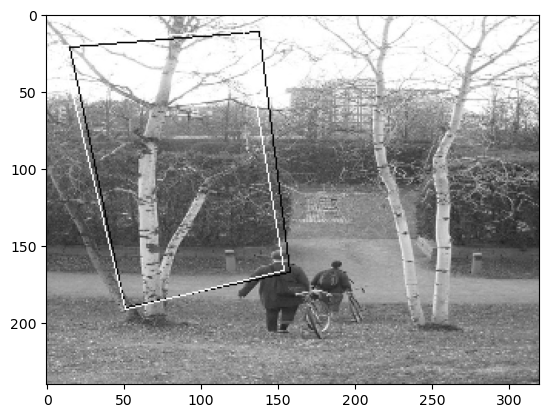

In [23]:
Visualize(model, folder, files[3], plot_img = True)

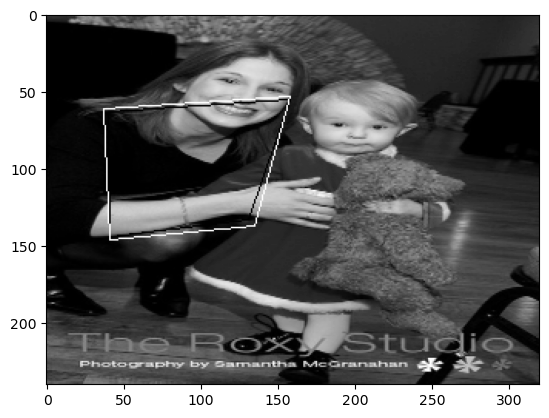

In [25]:
Visualize(model, folder, files[50], plot_img = True)

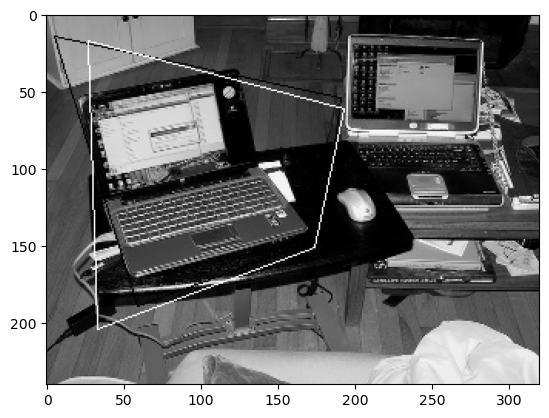

In [26]:
Visualize(model, folder, files[100], plot_img = True)